In [1]:
# Data Manipulation / Analysis Libraries
import pandas as pd
import numpy as np

# Deep Learning Libraries
import tensorflow as tf
from keras.models import Sequential    
from keras.layers import Dense       
from keras.layers import LSTM, GRU         
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from keras.models import load_model       
from keras.callbacks import EarlyStopping  
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

# Other Libraries
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import itertools
import pickle
import os

tf.random.set_seed(2110)

In [2]:
def get_stock_data(ticker):
    end_date = dt.date(2023, 5, 16)
    start_date = end_date - dt.timedelta(days=5*365)

    df = yf.download(ticker, start=start_date, end=end_date)
    
    return df

In [3]:
tlkm_data = get_stock_data("TLKM.JK")    # Perusahaan Perseroan (Persero) PT Telekomunikasi Indonesia Tbk.
xl_data = get_stock_data("EXCL.JK")      # PT XL Axiata Tbk.
tbig_data = get_stock_data("TBIG.JK")    # PT Tower Bersama Infrastructure Tbk.
towr_data = get_stock_data("TOWR.JK")    # PT Sarana Menara Nusantara Tbk.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def plot_adjusted_close_data(tlkm, xl, tbig, towr):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plot data on each subplot
    axs[0, 0].plot(tlkm.index, tlkm['Adj Close'])
    axs[0, 0].set_title('Telkom Adjusted Close')
    axs[0, 0].set_xlabel('Dates')
    axs[0, 0].set_ylabel('Price')

    axs[0, 1].plot(xl.index, xl['Adj Close'])
    axs[0, 1].set_title('XL Adjusted Close')
    axs[0, 1].set_xlabel('Dates')
    axs[0, 1].set_ylabel('Price')

    axs[1, 0].plot(tbig.index, tbig['Adj Close'])
    axs[1, 0].set_title('Tower Bersama Adjusted Close')
    axs[1, 0].set_xlabel('Dates')
    axs[1, 0].set_ylabel('Price')

    axs[1, 1].plot(towr.index, towr['Adj Close'])
    axs[1, 1].set_title('Sarana Menara Adjusted Close')
    axs[1, 1].set_xlabel('Dates')
    axs[1, 1].set_ylabel('Price')

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')

    # Show the combined plot
    plt.show()

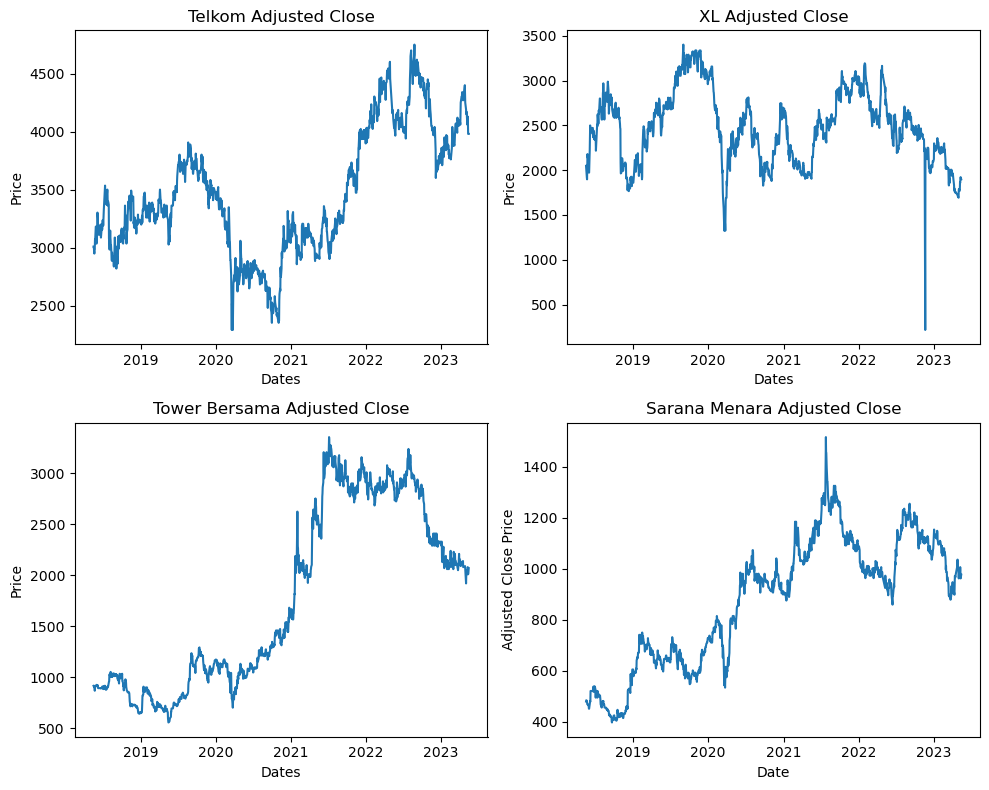

In [5]:
plot_adjusted_close_data(tlkm_data, xl_data, tbig_data, towr_data)

In [6]:
def handle_missing_value(df):
    
    num_missing = df.isnull().sum().sum()
    if num_missing > 0 :
        print("There are", num_missing, "missing value")
        df = df.dropna()
    else:
        print("No missing values")
        
    print(df)
    return df

In [7]:
print("---------------- Telkom Data ----------------")
tlkm_data = handle_missing_value(tlkm_data)
print("\n---------------- XL Data ----------------")
xl_data = handle_missing_value(xl_data)
print("\n---------------- Tower Bersama Data ----------------")
tbig_data = handle_missing_value(tbig_data)
print("\n---------------- Sarana Menara Data ----------------")
towr_data = handle_missing_value(towr_data)

---------------- Telkom Data ----------------
No missing values
              Open    High     Low   Close    Adj Close     Volume
Date                                                              
2018-05-17  3510.0  3610.0  3490.0  3490.0  3008.512451  179026500
2018-05-18  3520.0  3530.0  3400.0  3490.0  3008.512451   75748600
2018-05-21  3490.0  3490.0  3410.0  3420.0  2948.169678   57210900
2018-05-22  3420.0  3500.0  3420.0  3470.0  2991.271729   78667200
2018-05-23  3460.0  3530.0  3450.0  3470.0  2991.271729  110630200
...            ...     ...     ...     ...          ...        ...
2023-05-09  4050.0  4090.0  4030.0  4070.0  4070.000000  105907900
2023-05-10  4050.0  4130.0  4040.0  4130.0  4130.000000   84306600
2023-05-11  4100.0  4120.0  4060.0  4090.0  4090.000000   74171300
2023-05-12  4050.0  4050.0  3950.0  3980.0  3980.000000  236777600
2023-05-15  3990.0  3990.0  3930.0  3980.0  3980.000000  113329300

[1241 rows x 6 columns]

---------------- XL Data --------------

In [8]:
# shape is inconsistent on tbig, search for missing indices
missing_indices_tlkm = tbig_data[~tbig_data.index.isin(tlkm_data.index)]

print("Missing indices in tlkm_data:")
print(missing_indices_tlkm)

Missing indices in tlkm_data:
             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2019-06-19  792.0  794.0  756.0  768.0  726.958618  22390000


In [9]:
def select_and_scale_data(df):
    # Select ADJ Close column from data
    adj_close = df.filter(['Adj Close'])
    data_values = adj_close.values
    
    # Scale data with MinMax with range 0-1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data_values)
    
    return scaler, scaled_data

In [10]:
tlkm_scaler, scaled_tlkm = select_and_scale_data(tlkm_data)
xl_scaler, scaled_xl = select_and_scale_data(xl_data)
tbig_scaler, scaled_tbig = select_and_scale_data(tbig_data)
towr_scaler, scaled_towr = select_and_scale_data(towr_data)

In [11]:
print("telkom scaler = " + str(tlkm_scaler.scale_))
print("excl scaler = " + str(xl_scaler.scale_))
print("tbig scaler = " + str(tbig_scaler.scale_))
print("towr scaler = " + str(towr_scaler.scale_))

telkom scaler = [0.00040644]
excl scaler = [0.00031409]
tbig scaler = [0.00035702]
towr scaler = [0.00089451]


In [12]:
# Save scaler to use later
with open('tlkm_scaler.pkl', 'wb') as file:
    pickle.dump(tlkm_scaler, file)
with open('xl_scaler.pkl', 'wb') as file:
    pickle.dump(xl_scaler, file)
with open('tbig_scaler.pkl', 'wb') as file:
    pickle.dump(tbig_scaler, file)
with open('towr_scaler.pkl', 'wb') as file:
    pickle.dump(towr_scaler, file)

In [13]:
def split_input_output(data, distance):
    x = []
    y = []
    
    for i in range(distance, len(data)):
        x.append(data[i-distance:i, 0])
        y.append(data[i, 0])
    
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    
    return x, y

In [14]:
def split_scaled_data(scaled_data, split_ratio):
    split_index = int(len(scaled_data) * split_ratio)
    
    train_data_scaled = scaled_data[0:split_index, :]
    test_data_scaled = scaled_data[split_index - 60:, :]
    
    x_train, y_train = split_input_output(train_data_scaled, 60)
    x_test, y_test = split_input_output(test_data_scaled, 60)
    
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of x_test:", x_test.shape)
    print("Shape of y_test:", y_test.shape)
    
    return x_train, y_train, x_test, y_test

In [15]:
print("---------------- Telkom train-test Data ----------------")
tlkm_x_train, tlkm_y_train, tlkm_x_test, tlkm_y_test = split_scaled_data(scaled_tlkm, 0.7)
print("\n---------------- XL train-test Data ----------------")
xl_x_train, xl_y_train, xl_x_test, xl_y_test = split_scaled_data(scaled_xl, 0.7)
print("\n---------------- Tower Bersama train-test Data ----------------")
tbig_x_train, tbig_y_train, tbig_x_test, tbig_y_test = split_scaled_data(scaled_tbig, 0.7)
print("\n---------------- Sarana Menara train-test Data ----------------")
towr_x_train, towr_y_train, towr_x_test, towr_y_test = split_scaled_data(scaled_towr, 0.7)

---------------- Telkom train-test Data ----------------
Shape of x_train: (808, 60, 1)
Shape of y_train: (808,)
Shape of x_test: (373, 60, 1)
Shape of y_test: (373,)

---------------- XL train-test Data ----------------
Shape of x_train: (808, 60, 1)
Shape of y_train: (808,)
Shape of x_test: (373, 60, 1)
Shape of y_test: (373,)

---------------- Tower Bersama train-test Data ----------------
Shape of x_train: (809, 60, 1)
Shape of y_train: (809,)
Shape of x_test: (373, 60, 1)
Shape of y_test: (373,)

---------------- Sarana Menara train-test Data ----------------
Shape of x_train: (808, 60, 1)
Shape of y_train: (808,)
Shape of x_test: (373, 60, 1)
Shape of y_test: (373,)


In [16]:
def lstm_parameter_tuning(stock, config, x_train, y_train, x_test, y_test):
    neurons_1, neurons_2, batch_size, dropout = config
    possible_combinations = list(itertools.product(neurons_1, neurons_2, batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    best_loss = float('inf')  # Initialize the best loss as infinity
    best_model = None
    best_history = None
    
    hist = []
    for i in range(0, len(possible_combinations)):
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        neurons_1, neurons_2, batch_size, dropout = possible_combinations[i]

        model = Sequential()
        model.add(LSTM(units=neurons_1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(dropout))
        model.add(LSTM(units=neurons_2, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.RootMeanSquaredError()])
        
        file_path = stock + '_best_model.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=batch_size, callbacks=[es, mc], verbose=0)

        train_accuracy = model.evaluate(x_train, y_train, verbose=0)
        test_accuracy = model.evaluate(x_test, y_test, verbose=0)

        hist.append(list((neurons_1, neurons_2, batch_size, dropout, train_accuracy, test_accuracy))) 

        # Compare current model's validation loss with the best loss
        if test_accuracy[0] < best_loss:
            print("Model is better than before")
            best_loss = test_accuracy[0]
            if best_model is not None:
                # Delete previous best model
                print("Replacing previous model")

            best_model = load_model(file_path)  # Load the best model
            best_history = history
            
        print("current best loss: " + str(best_loss))

        print(f'{str(i+1)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist, best_model, best_history


In [17]:
def evaluate_best_param(tuning):
    res = pd.DataFrame(tuning)
    res = res.sort_values(by=[5], ascending=True)
    
    print("Best Combination:")
    print(f"neurons_1 = {res.iloc[0, 0]}")
    print(f"neurons_2 = {res.iloc[0, 1]}")
    print(f"batch_size = {res.iloc[0, 2]}")
    print(f"dropout = {res.iloc[0, 3]}")
    
    return res

In [18]:
lstm_param_config = [
    [32, 64, 128], # neuron 1
    [32, 64, 128], # neuron 2
    [16, 32],      # batch_size
    [0.2, 0.3]     # dropout_rate
]

In [19]:
telkom_tune, tlkm_model, telkom_hist = lstm_parameter_tuning("TLKM", lstm_param_config, tlkm_x_train, tlkm_y_train, tlkm_x_test, tlkm_y_test)

[(32, 32, 16, 0.2), (32, 32, 16, 0.3), (32, 32, 32, 0.2), (32, 32, 32, 0.3), (32, 64, 16, 0.2), (32, 64, 16, 0.3), (32, 64, 32, 0.2), (32, 64, 32, 0.3), (32, 128, 16, 0.2), (32, 128, 16, 0.3), (32, 128, 32, 0.2), (32, 128, 32, 0.3), (64, 32, 16, 0.2), (64, 32, 16, 0.3), (64, 32, 32, 0.2), (64, 32, 32, 0.3), (64, 64, 16, 0.2), (64, 64, 16, 0.3), (64, 64, 32, 0.2), (64, 64, 32, 0.3), (64, 128, 16, 0.2), (64, 128, 16, 0.3), (64, 128, 32, 0.2), (64, 128, 32, 0.3), (128, 32, 16, 0.2), (128, 32, 16, 0.3), (128, 32, 32, 0.2), (128, 32, 32, 0.3), (128, 64, 16, 0.2), (128, 64, 16, 0.3), (128, 64, 32, 0.2), (128, 64, 32, 0.3), (128, 128, 16, 0.2), (128, 128, 16, 0.3), (128, 128, 32, 0.2), (128, 128, 32, 0.3)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.01763, saving model to TLKM_best_model.h5

Epoch 2: val_loss improved from 0.01763 to 0.00701, saving model to TLKM_best_model.h5

Epoch 3: val_loss improved f


Epoch 18: val_loss did not improve from 0.00216

Epoch 19: val_loss improved from 0.00216 to 0.00205, saving model to TLKM_best_model.h5

Epoch 20: val_loss did not improve from 0.00205

Epoch 21: val_loss did not improve from 0.00205

Epoch 22: val_loss improved from 0.00205 to 0.00194, saving model to TLKM_best_model.h5

Epoch 23: val_loss did not improve from 0.00194

Epoch 24: val_loss did not improve from 0.00194

Epoch 25: val_loss did not improve from 0.00194

Epoch 26: val_loss did not improve from 0.00194

Epoch 27: val_loss did not improve from 0.00194
Epoch 27: early stopping
current best loss: 0.00167006382253021
4-th combination = (32, 32, 32, 0.3) 
 train accuracy: [0.001804510597139597, 0.04247952997684479] and test accuracy: [0.0019845180213451385, 0.04454793035984039]
--------------------------------------------------------------------
--------------------------------------------------------------------
-----------------------------------------------------------------


Epoch 7: val_loss improved from 0.00223 to 0.00190, saving model to TLKM_best_model.h5

Epoch 8: val_loss did not improve from 0.00190

Epoch 9: val_loss did not improve from 0.00190

Epoch 10: val_loss improved from 0.00190 to 0.00176, saving model to TLKM_best_model.h5

Epoch 11: val_loss did not improve from 0.00176

Epoch 12: val_loss did not improve from 0.00176

Epoch 13: val_loss did not improve from 0.00176

Epoch 14: val_loss did not improve from 0.00176

Epoch 15: val_loss did not improve from 0.00176
Epoch 15: early stopping
current best loss: 0.00167006382253021
9-th combination = (32, 128, 16, 0.2) 
 train accuracy: [0.001687931828200817, 0.041084446012973785] and test accuracy: [0.005180864594876766, 0.07197822630405426]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
-----------------------------------------------

current best loss: 0.0012616741005331278
13-th combination = (64, 32, 16, 0.2) 
 train accuracy: [0.0010785091435536742, 0.03284066170454025] and test accuracy: [0.0012616741005331278, 0.035520050674676895]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
14th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.02013, saving model to TLKM_best_model.h5

Epoch 2: val_loss improved from 0.02013 to 0.00577, saving model to TLKM_best_model.h5

Epoch 3: val_loss did not improve from 0.00577

Epoch 4: val_loss did not improve from 0.00577

Epoch 5: val_loss improved from 0.00577 to 0.00238, saving model to TLKM_best_model.h5

Epoch 6: val_loss did not improve from 0.00238

Epoch 7: val_loss did n


Epoch 1: val_loss improved from inf to 0.00497, saving model to TLKM_best_model.h5

Epoch 2: val_loss improved from 0.00497 to 0.00479, saving model to TLKM_best_model.h5

Epoch 3: val_loss improved from 0.00479 to 0.00231, saving model to TLKM_best_model.h5

Epoch 4: val_loss did not improve from 0.00231

Epoch 5: val_loss did not improve from 0.00231

Epoch 6: val_loss did not improve from 0.00231

Epoch 7: val_loss did not improve from 0.00231

Epoch 8: val_loss improved from 0.00231 to 0.00169, saving model to TLKM_best_model.h5

Epoch 9: val_loss did not improve from 0.00169

Epoch 10: val_loss did not improve from 0.00169

Epoch 11: val_loss did not improve from 0.00169

Epoch 12: val_loss did not improve from 0.00169

Epoch 13: val_loss did not improve from 0.00169
Epoch 13: early stopping
current best loss: 0.0012616741005331278
17-th combination = (64, 64, 16, 0.2) 
 train accuracy: [0.0015532635152339935, 0.03941146284341812] and test accuracy: [0.0028238208033144474, 0.0531


Epoch 23: val_loss improved from 0.00159 to 0.00136, saving model to TLKM_best_model.h5

Epoch 24: val_loss did not improve from 0.00136

Epoch 25: val_loss did not improve from 0.00136

Epoch 26: val_loss did not improve from 0.00136

Epoch 27: val_loss did not improve from 0.00136

Epoch 28: val_loss did not improve from 0.00136
Epoch 28: early stopping
current best loss: 0.0010091970907524228
20-th combination = (64, 64, 32, 0.3) 
 train accuracy: [0.0012789752800017595, 0.035762764513492584] and test accuracy: [0.0013714531669393182, 0.03703313693404198]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
21th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00361, saving model to TLKM


Epoch 1: val_loss improved from inf to 0.00791, saving model to TLKM_best_model.h5

Epoch 2: val_loss improved from 0.00791 to 0.00330, saving model to TLKM_best_model.h5

Epoch 3: val_loss did not improve from 0.00330

Epoch 4: val_loss did not improve from 0.00330

Epoch 5: val_loss did not improve from 0.00330

Epoch 6: val_loss improved from 0.00330 to 0.00200, saving model to TLKM_best_model.h5

Epoch 7: val_loss did not improve from 0.00200

Epoch 8: val_loss improved from 0.00200 to 0.00183, saving model to TLKM_best_model.h5

Epoch 9: val_loss did not improve from 0.00183

Epoch 10: val_loss did not improve from 0.00183

Epoch 11: val_loss improved from 0.00183 to 0.00147, saving model to TLKM_best_model.h5

Epoch 12: val_loss did not improve from 0.00147

Epoch 13: val_loss did not improve from 0.00147

Epoch 14: val_loss improved from 0.00147 to 0.00128, saving model to TLKM_best_model.h5

Epoch 15: val_loss did not improve from 0.00128

Epoch 16: val_loss did not improve fr


Epoch 4: val_loss did not improve from 0.00258

Epoch 5: val_loss did not improve from 0.00258

Epoch 6: val_loss improved from 0.00258 to 0.00254, saving model to TLKM_best_model.h5

Epoch 7: val_loss did not improve from 0.00254

Epoch 8: val_loss did not improve from 0.00254

Epoch 9: val_loss did not improve from 0.00254

Epoch 10: val_loss did not improve from 0.00254

Epoch 11: val_loss did not improve from 0.00254
Epoch 11: early stopping
current best loss: 0.0010091970907524228
30-th combination = (128, 64, 16, 0.3) 
 train accuracy: [0.001404161681421101, 0.03747214376926422] and test accuracy: [0.003032116452232003, 0.05506465584039688]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
31th combination: 

------------------------------------------------

Epoch 16: early stopping
current best loss: 0.0010091970907524228
33-th combination = (128, 128, 16, 0.2) 
 train accuracy: [0.001953992061316967, 0.044203981757164] and test accuracy: [0.002926090732216835, 0.05409335345029831]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
34th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00327, saving model to TLKM_best_model.h5

Epoch 2: val_loss did not improve from 0.00327

Epoch 3: val_loss improved from 0.00327 to 0.00227, saving model to TLKM_best_model.h5

Epoch 4: val_loss did not improve from 0.00227

Epoch 5: val_loss did not improve from 0.00227

Epoch 6: val_loss improved from 0.00227 to 0.00156, saving model to TLKM_best_model.h5

E

In [20]:
tlkm_model.save('TLKM_best_model.h5')

In [21]:
xl_tune, excl_model, excl_hist = lstm_parameter_tuning("EXCL", lstm_param_config, xl_x_train, xl_y_train, xl_x_test, xl_y_test)

[(32, 32, 16, 0.2), (32, 32, 16, 0.3), (32, 32, 32, 0.2), (32, 32, 32, 0.3), (32, 64, 16, 0.2), (32, 64, 16, 0.3), (32, 64, 32, 0.2), (32, 64, 32, 0.3), (32, 128, 16, 0.2), (32, 128, 16, 0.3), (32, 128, 32, 0.2), (32, 128, 32, 0.3), (64, 32, 16, 0.2), (64, 32, 16, 0.3), (64, 32, 32, 0.2), (64, 32, 32, 0.3), (64, 64, 16, 0.2), (64, 64, 16, 0.3), (64, 64, 32, 0.2), (64, 64, 32, 0.3), (64, 128, 16, 0.2), (64, 128, 16, 0.3), (64, 128, 32, 0.2), (64, 128, 32, 0.3), (128, 32, 16, 0.2), (128, 32, 16, 0.3), (128, 32, 32, 0.2), (128, 32, 32, 0.3), (128, 64, 16, 0.2), (128, 64, 16, 0.3), (128, 64, 32, 0.2), (128, 64, 32, 0.3), (128, 128, 16, 0.2), (128, 128, 16, 0.3), (128, 128, 32, 0.2), (128, 128, 32, 0.3)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00341, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.00341 to 0.00285, saving model to EXCL_best_model.h5

Epoch 3: val_loss did not im

current best loss: 0.002083245199173689
3-th combination = (32, 32, 32, 0.2) 
 train accuracy: [0.0023800437338650227, 0.04878569021821022] and test accuracy: [0.003386328462511301, 0.058192167431116104]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
4th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.01330, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.01330 to 0.00473, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00473 to 0.00424, saving model to EXCL_best_model.h5

Epoch 4: val_loss improved from 0.00424 to 0.00370, saving model to EXCL_best_model.h5

Epoch 5: val_loss did not improve from 0.00370

Epoch 6: val_loss improved from 0.0


Epoch 10: val_loss did not improve from 0.00272

Epoch 11: val_loss improved from 0.00272 to 0.00270, saving model to EXCL_best_model.h5

Epoch 12: val_loss did not improve from 0.00270

Epoch 13: val_loss improved from 0.00270 to 0.00264, saving model to EXCL_best_model.h5

Epoch 14: val_loss did not improve from 0.00264

Epoch 15: val_loss did not improve from 0.00264

Epoch 16: val_loss did not improve from 0.00264

Epoch 17: val_loss did not improve from 0.00264

Epoch 18: val_loss improved from 0.00264 to 0.00263, saving model to EXCL_best_model.h5

Epoch 19: val_loss improved from 0.00263 to 0.00255, saving model to EXCL_best_model.h5

Epoch 20: val_loss did not improve from 0.00255

Epoch 21: val_loss did not improve from 0.00255

Epoch 22: val_loss did not improve from 0.00255

Epoch 23: val_loss did not improve from 0.00255

Epoch 24: val_loss did not improve from 0.00255
Epoch 24: early stopping
current best loss: 0.002083245199173689
7-th combination = (32, 64, 32, 0.2) 
 t


Epoch 14: val_loss did not improve from 0.00262
Epoch 14: early stopping
current best loss: 0.002083245199173689
11-th combination = (32, 128, 32, 0.2) 
 train accuracy: [0.003670367179438472, 0.060583554208278656] and test accuracy: [0.0038767713122069836, 0.06226372346282005]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
12th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00563, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.00563 to 0.00309, saving model to EXCL_best_model.h5

Epoch 3: val_loss did not improve from 0.00309

Epoch 4: val_loss improved from 0.00309 to 0.00298, saving model to EXCL_best_model.h5

Epoch 5: val_loss improved from 0.00298 to 0.0


Epoch 1: val_loss improved from inf to 0.01609, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.01609 to 0.00420, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00420 to 0.00374, saving model to EXCL_best_model.h5

Epoch 4: val_loss improved from 0.00374 to 0.00327, saving model to EXCL_best_model.h5

Epoch 5: val_loss did not improve from 0.00327

Epoch 6: val_loss did not improve from 0.00327

Epoch 7: val_loss improved from 0.00327 to 0.00313, saving model to EXCL_best_model.h5

Epoch 8: val_loss did not improve from 0.00313

Epoch 9: val_loss did not improve from 0.00313

Epoch 10: val_loss did not improve from 0.00313

Epoch 11: val_loss did not improve from 0.00313

Epoch 12: val_loss did not improve from 0.00313
Epoch 12: early stopping
current best loss: 0.002083245199173689
16-th combination = (64, 32, 32, 0.3) 
 train accuracy: [0.003512980882078409, 0.059270404279232025] and test accuracy: [0.0035970525350421667, 0.05997543409466


Epoch 2: val_loss improved from 0.00465 to 0.00374, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00374 to 0.00367, saving model to EXCL_best_model.h5

Epoch 4: val_loss improved from 0.00367 to 0.00286, saving model to EXCL_best_model.h5

Epoch 5: val_loss did not improve from 0.00286

Epoch 6: val_loss improved from 0.00286 to 0.00269, saving model to EXCL_best_model.h5

Epoch 7: val_loss did not improve from 0.00269

Epoch 8: val_loss improved from 0.00269 to 0.00266, saving model to EXCL_best_model.h5

Epoch 9: val_loss did not improve from 0.00266

Epoch 10: val_loss did not improve from 0.00266

Epoch 11: val_loss improved from 0.00266 to 0.00259, saving model to EXCL_best_model.h5

Epoch 12: val_loss improved from 0.00259 to 0.00253, saving model to EXCL_best_model.h5

Epoch 13: val_loss did not improve from 0.00253

Epoch 14: val_loss did not improve from 0.00253

Epoch 15: val_loss did not improve from 0.00253

Epoch 16: val_loss improved from 0.00253 


Epoch 15: val_loss did not improve from 0.00254
Epoch 15: early stopping
current best loss: 0.002083245199173689
23-th combination = (64, 128, 32, 0.2) 
 train accuracy: [0.002305503934621811, 0.048015665262937546] and test accuracy: [0.0033376463688910007, 0.05777236819267273]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
24th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.01164, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.01164 to 0.00325, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00325 to 0.00306, saving model to EXCL_best_model.h5

Epoch 4: val_loss did not improve from 0.00306

Epoch 5: val_loss improved from 0.00306 to 0.0


Epoch 1: val_loss improved from inf to 0.00740, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.00740 to 0.00468, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00468 to 0.00364, saving model to EXCL_best_model.h5

Epoch 4: val_loss improved from 0.00364 to 0.00361, saving model to EXCL_best_model.h5

Epoch 5: val_loss improved from 0.00361 to 0.00301, saving model to EXCL_best_model.h5

Epoch 6: val_loss did not improve from 0.00301

Epoch 7: val_loss improved from 0.00301 to 0.00274, saving model to EXCL_best_model.h5

Epoch 8: val_loss did not improve from 0.00274

Epoch 9: val_loss did not improve from 0.00274

Epoch 10: val_loss did not improve from 0.00274

Epoch 11: val_loss did not improve from 0.00274

Epoch 12: val_loss did not improve from 0.00274
Epoch 12: early stopping
current best loss: 0.0019260999979451299
27-th combination = (128, 32, 32, 0.2) 
 train accuracy: [0.002828048076480627, 0.05317939445376396] and test accuracy:


Epoch 7: val_loss did not improve from 0.00261

Epoch 8: val_loss improved from 0.00261 to 0.00257, saving model to EXCL_best_model.h5

Epoch 9: val_loss did not improve from 0.00257

Epoch 10: val_loss did not improve from 0.00257

Epoch 11: val_loss did not improve from 0.00257

Epoch 12: val_loss did not improve from 0.00257

Epoch 13: val_loss improved from 0.00257 to 0.00257, saving model to EXCL_best_model.h5

Epoch 14: val_loss did not improve from 0.00257

Epoch 15: val_loss improved from 0.00257 to 0.00245, saving model to EXCL_best_model.h5

Epoch 16: val_loss did not improve from 0.00245

Epoch 17: val_loss improved from 0.00245 to 0.00242, saving model to EXCL_best_model.h5

Epoch 18: val_loss improved from 0.00242 to 0.00240, saving model to EXCL_best_model.h5

Epoch 19: val_loss improved from 0.00240 to 0.00240, saving model to EXCL_best_model.h5

Epoch 20: val_loss did not improve from 0.00240

Epoch 21: val_loss did not improve from 0.00240

Epoch 22: val_loss did not 


Epoch 1: val_loss improved from inf to 0.00553, saving model to EXCL_best_model.h5

Epoch 2: val_loss improved from 0.00553 to 0.00331, saving model to EXCL_best_model.h5

Epoch 3: val_loss improved from 0.00331 to 0.00267, saving model to EXCL_best_model.h5

Epoch 4: val_loss did not improve from 0.00267

Epoch 5: val_loss improved from 0.00267 to 0.00254, saving model to EXCL_best_model.h5

Epoch 6: val_loss did not improve from 0.00254

Epoch 7: val_loss improved from 0.00254 to 0.00247, saving model to EXCL_best_model.h5

Epoch 8: val_loss did not improve from 0.00247

Epoch 9: val_loss did not improve from 0.00247

Epoch 10: val_loss did not improve from 0.00247

Epoch 11: val_loss did not improve from 0.00247

Epoch 12: val_loss improved from 0.00247 to 0.00239, saving model to EXCL_best_model.h5

Epoch 13: val_loss did not improve from 0.00239

Epoch 14: val_loss did not improve from 0.00239

Epoch 15: val_loss did not improve from 0.00239

Epoch 16: val_loss improved from 0.00

In [22]:
excl_model.save('EXCL_best_model.h5')

In [23]:
tbig_tune, tbig_model, tbig_hist = lstm_parameter_tuning("TBIG", lstm_param_config, tbig_x_train, tbig_y_train, tbig_x_test, tbig_y_test)

[(32, 32, 16, 0.2), (32, 32, 16, 0.3), (32, 32, 32, 0.2), (32, 32, 32, 0.3), (32, 64, 16, 0.2), (32, 64, 16, 0.3), (32, 64, 32, 0.2), (32, 64, 32, 0.3), (32, 128, 16, 0.2), (32, 128, 16, 0.3), (32, 128, 32, 0.2), (32, 128, 32, 0.3), (64, 32, 16, 0.2), (64, 32, 16, 0.3), (64, 32, 32, 0.2), (64, 32, 32, 0.3), (64, 64, 16, 0.2), (64, 64, 16, 0.3), (64, 64, 32, 0.2), (64, 64, 32, 0.3), (64, 128, 16, 0.2), (64, 128, 16, 0.3), (64, 128, 32, 0.2), (64, 128, 32, 0.3), (128, 32, 16, 0.2), (128, 32, 16, 0.3), (128, 32, 32, 0.2), (128, 32, 32, 0.3), (128, 64, 16, 0.2), (128, 64, 16, 0.3), (128, 64, 32, 0.2), (128, 64, 32, 0.3), (128, 128, 16, 0.2), (128, 128, 16, 0.3), (128, 128, 32, 0.2), (128, 128, 32, 0.3)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00823, saving model to TBIG_best_model.h5

Epoch 2: val_loss improved from 0.00823 to 0.00361, saving model to TBIG_best_model.h5

Epoch 3: val_loss improved f


Epoch 3: val_loss did not improve from 0.00171

Epoch 4: val_loss improved from 0.00171 to 0.00103, saving model to TBIG_best_model.h5

Epoch 5: val_loss did not improve from 0.00103

Epoch 6: val_loss improved from 0.00103 to 0.00099, saving model to TBIG_best_model.h5

Epoch 7: val_loss did not improve from 0.00099

Epoch 8: val_loss did not improve from 0.00099

Epoch 9: val_loss did not improve from 0.00099

Epoch 10: val_loss improved from 0.00099 to 0.00097, saving model to TBIG_best_model.h5

Epoch 11: val_loss improved from 0.00097 to 0.00077, saving model to TBIG_best_model.h5

Epoch 12: val_loss did not improve from 0.00077

Epoch 13: val_loss did not improve from 0.00077

Epoch 14: val_loss did not improve from 0.00077

Epoch 15: val_loss did not improve from 0.00077

Epoch 16: val_loss did not improve from 0.00077
Epoch 16: early stopping
current best loss: 0.0008771243738010526
6-th combination = (32, 64, 16, 0.3) 
 train accuracy: [0.0012870627688243985, 0.03587565571069


Epoch 18: val_loss did not improve from 0.00075

Epoch 19: val_loss improved from 0.00075 to 0.00073, saving model to TBIG_best_model.h5

Epoch 20: val_loss did not improve from 0.00073

Epoch 21: val_loss did not improve from 0.00073

Epoch 22: val_loss improved from 0.00073 to 0.00067, saving model to TBIG_best_model.h5

Epoch 23: val_loss did not improve from 0.00067

Epoch 24: val_loss did not improve from 0.00067

Epoch 25: val_loss did not improve from 0.00067

Epoch 26: val_loss did not improve from 0.00067

Epoch 27: val_loss improved from 0.00067 to 0.00064, saving model to TBIG_best_model.h5

Epoch 28: val_loss did not improve from 0.00064

Epoch 29: val_loss did not improve from 0.00064

Epoch 30: val_loss did not improve from 0.00064

Epoch 31: val_loss did not improve from 0.00064

Epoch 32: val_loss did not improve from 0.00064
Epoch 32: early stopping
Model is better than before
Replacing previous model
current best loss: 0.0006649880087934434
11-th combination = (32, 1


Epoch 15: val_loss did not improve from 0.00095

Epoch 16: val_loss did not improve from 0.00095

Epoch 17: val_loss did not improve from 0.00095

Epoch 18: val_loss did not improve from 0.00095
Epoch 18: early stopping
current best loss: 0.0006649880087934434
16-th combination = (64, 32, 32, 0.3) 
 train accuracy: [0.0013188463635742664, 0.0363159254193306] and test accuracy: [0.0011881316313520074, 0.03446928411722183]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
17th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00214, saving model to TBIG_best_model.h5

Epoch 2: val_loss did not improve from 0.00214

Epoch 3: val_loss did not improve from 0.00214

Epoch 4: val_loss improved f


Epoch 28: val_loss improved from 0.00073 to 0.00071, saving model to TBIG_best_model.h5

Epoch 29: val_loss improved from 0.00071 to 0.00070, saving model to TBIG_best_model.h5

Epoch 30: val_loss did not improve from 0.00070

Epoch 31: val_loss did not improve from 0.00070

Epoch 32: val_loss did not improve from 0.00070

Epoch 33: val_loss did not improve from 0.00070

Epoch 34: val_loss did not improve from 0.00070
Epoch 34: early stopping
current best loss: 0.0006649880087934434
20-th combination = (64, 64, 32, 0.3) 
 train accuracy: [0.0008077601087279618, 0.02842112071812153] and test accuracy: [0.000881840824149549, 0.02969580516219139]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
21th combination: 

---------------------------------------------------


Epoch 6: val_loss did not improve from 0.00089

Epoch 7: val_loss did not improve from 0.00089

Epoch 8: val_loss improved from 0.00089 to 0.00088, saving model to TBIG_best_model.h5

Epoch 9: val_loss did not improve from 0.00088

Epoch 10: val_loss did not improve from 0.00088

Epoch 11: val_loss did not improve from 0.00088

Epoch 12: val_loss did not improve from 0.00088

Epoch 13: val_loss improved from 0.00088 to 0.00072, saving model to TBIG_best_model.h5

Epoch 14: val_loss did not improve from 0.00072

Epoch 15: val_loss did not improve from 0.00072

Epoch 16: val_loss did not improve from 0.00072

Epoch 17: val_loss did not improve from 0.00072

Epoch 18: val_loss did not improve from 0.00072
Epoch 18: early stopping
current best loss: 0.0006649880087934434
26-th combination = (128, 32, 16, 0.3) 
 train accuracy: [0.0011479835957288742, 0.03388190641999245] and test accuracy: [0.0017792393919080496, 0.04218102991580963]
-------------------------------------------------------


Epoch 18: val_loss did not improve from 0.00062

Epoch 19: val_loss did not improve from 0.00062

Epoch 20: val_loss did not improve from 0.00062

Epoch 21: val_loss did not improve from 0.00062

Epoch 22: val_loss did not improve from 0.00062
Epoch 22: early stopping
current best loss: 0.0006649880087934434
31-th combination = (128, 64, 32, 0.2) 
 train accuracy: [0.001783168176189065, 0.04222757741808891] and test accuracy: [0.0030207824893295765, 0.05496164411306381]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
32th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00678, saving model to TBIG_best_model.h5

Epoch 2: val_loss did not improve from 0.00678

Epoch 3: val_loss improved


Epoch 9: val_loss did not improve from 0.00078

Epoch 10: val_loss did not improve from 0.00078

Epoch 11: val_loss improved from 0.00078 to 0.00067, saving model to TBIG_best_model.h5

Epoch 12: val_loss did not improve from 0.00067

Epoch 13: val_loss improved from 0.00067 to 0.00067, saving model to TBIG_best_model.h5

Epoch 14: val_loss improved from 0.00067 to 0.00064, saving model to TBIG_best_model.h5

Epoch 15: val_loss did not improve from 0.00064

Epoch 16: val_loss did not improve from 0.00064

Epoch 17: val_loss did not improve from 0.00064

Epoch 18: val_loss improved from 0.00064 to 0.00062, saving model to TBIG_best_model.h5

Epoch 19: val_loss did not improve from 0.00062

Epoch 20: val_loss did not improve from 0.00062

Epoch 21: val_loss did not improve from 0.00062

Epoch 22: val_loss did not improve from 0.00062

Epoch 23: val_loss did not improve from 0.00062
Epoch 23: early stopping
current best loss: 0.0006649880087934434
36-th combination = (128, 128, 32, 0.3) 

In [24]:
tbig_model.save('TBIG_best_model.h5')

In [25]:
towr_tune, towr_model, towr_hist = lstm_parameter_tuning("towr", lstm_param_config, towr_x_train, towr_y_train, towr_x_test, towr_y_test)

[(32, 32, 16, 0.2), (32, 32, 16, 0.3), (32, 32, 32, 0.2), (32, 32, 32, 0.3), (32, 64, 16, 0.2), (32, 64, 16, 0.3), (32, 64, 32, 0.2), (32, 64, 32, 0.3), (32, 128, 16, 0.2), (32, 128, 16, 0.3), (32, 128, 32, 0.2), (32, 128, 32, 0.3), (64, 32, 16, 0.2), (64, 32, 16, 0.3), (64, 32, 32, 0.2), (64, 32, 32, 0.3), (64, 64, 16, 0.2), (64, 64, 16, 0.3), (64, 64, 32, 0.2), (64, 64, 32, 0.3), (64, 128, 16, 0.2), (64, 128, 16, 0.3), (64, 128, 32, 0.2), (64, 128, 32, 0.3), (128, 32, 16, 0.2), (128, 32, 16, 0.3), (128, 32, 32, 0.2), (128, 32, 32, 0.3), (128, 64, 16, 0.2), (128, 64, 16, 0.3), (128, 64, 32, 0.2), (128, 64, 32, 0.3), (128, 128, 16, 0.2), (128, 128, 16, 0.3), (128, 128, 32, 0.2), (128, 128, 32, 0.3)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00408, saving model to towr_best_model.h5

Epoch 2: val_loss improved from 0.00408 to 0.00300, saving model to towr_best_model.h5

Epoch 3: val_loss improved f


Epoch 1: val_loss improved from inf to 0.00168, saving model to towr_best_model.h5

Epoch 2: val_loss improved from 0.00168 to 0.00134, saving model to towr_best_model.h5

Epoch 3: val_loss improved from 0.00134 to 0.00129, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00129

Epoch 5: val_loss improved from 0.00129 to 0.00107, saving model to towr_best_model.h5

Epoch 6: val_loss did not improve from 0.00107

Epoch 7: val_loss improved from 0.00107 to 0.00105, saving model to towr_best_model.h5

Epoch 8: val_loss improved from 0.00105 to 0.00094, saving model to towr_best_model.h5

Epoch 9: val_loss did not improve from 0.00094

Epoch 10: val_loss did not improve from 0.00094

Epoch 11: val_loss improved from 0.00094 to 0.00090, saving model to towr_best_model.h5

Epoch 12: val_loss did not improve from 0.00090

Epoch 13: val_loss did not improve from 0.00090

Epoch 14: val_loss did not improve from 0.00090

Epoch 15: val_loss did not improve from 0.0009


Epoch 1: val_loss improved from inf to 0.00123, saving model to towr_best_model.h5

Epoch 2: val_loss did not improve from 0.00123

Epoch 3: val_loss improved from 0.00123 to 0.00113, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00113

Epoch 5: val_loss improved from 0.00113 to 0.00101, saving model to towr_best_model.h5

Epoch 6: val_loss did not improve from 0.00101

Epoch 7: val_loss did not improve from 0.00101

Epoch 8: val_loss did not improve from 0.00101

Epoch 9: val_loss did not improve from 0.00101

Epoch 10: val_loss improved from 0.00101 to 0.00088, saving model to towr_best_model.h5

Epoch 11: val_loss improved from 0.00088 to 0.00083, saving model to towr_best_model.h5

Epoch 12: val_loss improved from 0.00083 to 0.00081, saving model to towr_best_model.h5

Epoch 13: val_loss did not improve from 0.00081

Epoch 14: val_loss did not improve from 0.00081

Epoch 15: val_loss did not improve from 0.00081

Epoch 16: val_loss improved from 0.00


Epoch 32: val_loss did not improve from 0.00061

Epoch 33: val_loss improved from 0.00061 to 0.00057, saving model to towr_best_model.h5

Epoch 34: val_loss did not improve from 0.00057

Epoch 35: val_loss did not improve from 0.00057

Epoch 36: val_loss did not improve from 0.00057

Epoch 37: val_loss improved from 0.00057 to 0.00057, saving model to towr_best_model.h5

Epoch 38: val_loss improved from 0.00057 to 0.00056, saving model to towr_best_model.h5

Epoch 39: val_loss did not improve from 0.00056

Epoch 40: val_loss did not improve from 0.00056

Epoch 41: val_loss did not improve from 0.00056

Epoch 42: val_loss did not improve from 0.00056

Epoch 43: val_loss did not improve from 0.00056
Epoch 43: early stopping
Model is better than before
Replacing previous model
current best loss: 0.0006029506330378354
11-th combination = (32, 128, 32, 0.2) 
 train accuracy: [0.0006599376210942864, 0.025689251720905304] and test accuracy: [0.0006029506330378354, 0.024555053561925888]
-----


Epoch 1: val_loss improved from inf to 0.01430, saving model to towr_best_model.h5

Epoch 2: val_loss improved from 0.01430 to 0.00166, saving model to towr_best_model.h5

Epoch 3: val_loss improved from 0.00166 to 0.00135, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00135

Epoch 5: val_loss did not improve from 0.00135

Epoch 6: val_loss improved from 0.00135 to 0.00123, saving model to towr_best_model.h5

Epoch 7: val_loss did not improve from 0.00123

Epoch 8: val_loss did not improve from 0.00123

Epoch 9: val_loss did not improve from 0.00123

Epoch 10: val_loss did not improve from 0.00123

Epoch 11: val_loss improved from 0.00123 to 0.00121, saving model to towr_best_model.h5

Epoch 12: val_loss improved from 0.00121 to 0.00106, saving model to towr_best_model.h5

Epoch 13: val_loss did not improve from 0.00106

Epoch 14: val_loss improved from 0.00106 to 0.00104, saving model to towr_best_model.h5

Epoch 15: val_loss did not improve from 0.0010


Epoch 3: val_loss did not improve from 0.00120

Epoch 4: val_loss did not improve from 0.00120

Epoch 5: val_loss did not improve from 0.00120

Epoch 6: val_loss did not improve from 0.00120

Epoch 7: val_loss did not improve from 0.00120
Epoch 7: early stopping
current best loss: 0.0006029506330378354
18-th combination = (64, 64, 16, 0.3) 
 train accuracy: [0.0013066232204437256, 0.03614724427461624] and test accuracy: [0.0012006628094241023, 0.03465058282017708]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
19th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.00587, saving model to towr_best_model.h5

Epoch 2: val_loss improved from 0.00587 to 0.00127, saving model to towr_best_mo


Epoch 2: val_loss improved from 0.00162 to 0.00136, saving model to towr_best_model.h5

Epoch 3: val_loss improved from 0.00136 to 0.00112, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00112

Epoch 5: val_loss did not improve from 0.00112

Epoch 6: val_loss did not improve from 0.00112

Epoch 7: val_loss improved from 0.00112 to 0.00096, saving model to towr_best_model.h5

Epoch 8: val_loss did not improve from 0.00096

Epoch 9: val_loss did not improve from 0.00096

Epoch 10: val_loss improved from 0.00096 to 0.00081, saving model to towr_best_model.h5

Epoch 11: val_loss did not improve from 0.00081

Epoch 12: val_loss improved from 0.00081 to 0.00077, saving model to towr_best_model.h5

Epoch 13: val_loss did not improve from 0.00077

Epoch 14: val_loss did not improve from 0.00077

Epoch 15: val_loss did not improve from 0.00077

Epoch 16: val_loss improved from 0.00077 to 0.00069, saving model to towr_best_model.h5

Epoch 17: val_loss did not impro


Epoch 11: val_loss improved from 0.00090 to 0.00079, saving model to towr_best_model.h5

Epoch 12: val_loss did not improve from 0.00079

Epoch 13: val_loss did not improve from 0.00079

Epoch 14: val_loss improved from 0.00079 to 0.00068, saving model to towr_best_model.h5

Epoch 15: val_loss did not improve from 0.00068

Epoch 16: val_loss did not improve from 0.00068

Epoch 17: val_loss did not improve from 0.00068

Epoch 18: val_loss improved from 0.00068 to 0.00063, saving model to towr_best_model.h5

Epoch 19: val_loss improved from 0.00063 to 0.00063, saving model to towr_best_model.h5

Epoch 20: val_loss improved from 0.00063 to 0.00059, saving model to towr_best_model.h5

Epoch 21: val_loss did not improve from 0.00059

Epoch 22: val_loss did not improve from 0.00059

Epoch 23: val_loss improved from 0.00059 to 0.00059, saving model to towr_best_model.h5

Epoch 24: val_loss improved from 0.00059 to 0.00053, saving model to towr_best_model.h5

Epoch 25: val_loss did not improv


Epoch 1: val_loss improved from inf to 0.00374, saving model to towr_best_model.h5

Epoch 2: val_loss improved from 0.00374 to 0.00114, saving model to towr_best_model.h5

Epoch 3: val_loss improved from 0.00114 to 0.00099, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00099

Epoch 5: val_loss did not improve from 0.00099

Epoch 6: val_loss improved from 0.00099 to 0.00083, saving model to towr_best_model.h5

Epoch 7: val_loss did not improve from 0.00083

Epoch 8: val_loss did not improve from 0.00083

Epoch 9: val_loss improved from 0.00083 to 0.00075, saving model to towr_best_model.h5

Epoch 10: val_loss did not improve from 0.00075

Epoch 11: val_loss improved from 0.00075 to 0.00071, saving model to towr_best_model.h5

Epoch 12: val_loss did not improve from 0.00071

Epoch 13: val_loss did not improve from 0.00071

Epoch 14: val_loss did not improve from 0.00071

Epoch 15: val_loss did not improve from 0.00071

Epoch 16: val_loss improved from 0.00


Epoch 3: val_loss improved from 0.00111 to 0.00095, saving model to towr_best_model.h5

Epoch 4: val_loss did not improve from 0.00095

Epoch 5: val_loss did not improve from 0.00095

Epoch 6: val_loss improved from 0.00095 to 0.00086, saving model to towr_best_model.h5

Epoch 7: val_loss did not improve from 0.00086

Epoch 8: val_loss did not improve from 0.00086

Epoch 9: val_loss did not improve from 0.00086

Epoch 10: val_loss improved from 0.00086 to 0.00065, saving model to towr_best_model.h5

Epoch 11: val_loss improved from 0.00065 to 0.00059, saving model to towr_best_model.h5

Epoch 12: val_loss did not improve from 0.00059

Epoch 13: val_loss did not improve from 0.00059

Epoch 14: val_loss did not improve from 0.00059

Epoch 15: val_loss improved from 0.00059 to 0.00057, saving model to towr_best_model.h5

Epoch 16: val_loss did not improve from 0.00057

Epoch 17: val_loss did not improve from 0.00057

Epoch 18: val_loss did not improve from 0.00057

Epoch 19: val_loss did

In [26]:
towr_model.save('TOWR_best_model.h5')

In [27]:
best_telkom = evaluate_best_param(telkom_tune)

Best Combination:
neurons_1 = 64
neurons_2 = 64
batch_size = 32
dropout = 0.2


In [28]:
best_xl = evaluate_best_param(xl_tune)

Best Combination:
neurons_1 = 128
neurons_2 = 32
batch_size = 16
dropout = 0.2


In [29]:
best_tbig = evaluate_best_param(tbig_tune)

Best Combination:
neurons_1 = 32
neurons_2 = 128
batch_size = 32
dropout = 0.2


In [30]:
best_towr = evaluate_best_param(towr_tune)

Best Combination:
neurons_1 = 128
neurons_2 = 64
batch_size = 16
dropout = 0.2


In [31]:
best_telkom

,0,1,2,3,4,5
18,64,64,32,0.2,"[0.0009438350680284202, 0.03072189912199974]","[0.0010091970907524228, 0.031767863780260086]"
31,128,64,32,0.3,"[0.0009636354516260326, 0.03104247897863388]","[0.0010237257229164243, 0.03199571371078491]"
12,64,32,16,0.2,"[0.0010785091435536742, 0.03284066170454025]","[0.0012616741005331278, 0.035520050674676895]"
14,64,32,32,0.2,"[0.0010959487408399582, 0.033105116337537766]","[0.0013312078081071377, 0.03648572042584419]"
33,128,128,16,0.3,"[0.0009259731159545481, 0.03042980656027794]","[0.0013555750483646989, 0.036818135529756546]"
19,64,64,32,0.3,"[0.0012789752800017595, 0.035762764513492584]","[0.0013714531669393182, 0.03703313693404198]"
23,64,128,32,0.3,"[0.0014442001702263951, 0.038002632558345795]","[0.001460294472053647, 0.03821380063891411]"
20,64,128,16,0.2,"[0.0012558818561956286, 0.035438422113657]","[0.0014796105679124594, 0.0384657047688961]"
0,32,32,16,0.2,"[0.001342901960015297, 0.03664562851190567]","[0.00167006382253021, 0.040866415947675705]"
35,128,128,32,0.3,"[0.0011772169964388013, 0.03431059420108795]","[0.0017076373333111405, 0.04132356867194176]"


In [32]:
best_xl

,0,1,2,3,4,5
24,128,32,16,0.2,"[0.00083394959801808, 0.028878185898065567]","[0.0019260999979451299, 0.04388735443353653]"
0,32,32,16,0.2,"[0.0010927841067314148, 0.033057283610105515]","[0.002083245199173689, 0.04564258083701134]"
20,64,128,16,0.2,"[0.0009592558490112424, 0.03097185492515564]","[0.0020857802592217922, 0.045670341700315475]"
33,128,128,16,0.3,"[0.0011015153722837567, 0.0331890843808651]","[0.0021555537823587656, 0.04642794281244278]"
35,128,128,32,0.3,"[0.0014303120551630855, 0.03781946748495102]","[0.0023537492379546165, 0.048515453934669495]"
25,128,32,16,0.3,"[0.0015449707861989737, 0.03930611535906792]","[0.0023680333979427814, 0.048662442713975906]"
4,32,64,16,0.2,"[0.0015075475675985217, 0.03882715106010437]","[0.002373794559389353, 0.04872160404920578]"
9,32,128,16,0.3,"[0.0012862901203334332, 0.03586488589644432]","[0.0023957497905939817, 0.04894639551639557]"
21,64,128,16,0.3,"[0.001482752151787281, 0.03850651904940605]","[0.0024035819806158543, 0.04902634024620056]"
32,128,128,16,0.2,"[0.0012800677213817835, 0.03577803447842598]","[0.0024161571636795998, 0.04915442317724228]"


In [33]:
best_tbig

,0,1,2,3,4,5
10,32,128,32,0.2,"[0.00077513896394521, 0.027841318398714066]","[0.0006649880087934434, 0.025787360966205597]"
28,128,64,16,0.2,"[0.0007899730699136853, 0.028106460347771645]","[0.0007538017816841602, 0.02745545096695423]"
21,64,128,16,0.3,"[0.0007730491342954338, 0.027803761884570122]","[0.000785774493124336, 0.028031669557094574]"
23,64,128,32,0.3,"[0.0009551916155032814, 0.030906174331903458]","[0.0008340887143276632, 0.028880594298243523]"
0,32,32,16,0.2,"[0.0010393637930974364, 0.0322391651570797]","[0.0008771243738010526, 0.029616285115480423]"
19,64,64,32,0.3,"[0.0008077601087279618, 0.02842112071812153]","[0.000881840824149549, 0.02969580516219139]"
31,128,64,32,0.3,"[0.0009448985219933093, 0.030739201232790947]","[0.000888119509909302, 0.02980133332312107]"
32,128,128,16,0.2,"[0.0007493093726225197, 0.02737351506948471]","[0.0009028789936564863, 0.0300479456782341]"
4,32,64,16,0.2,"[0.0009142293711192906, 0.030236225575208664]","[0.0009968571830540895, 0.03157304599881172]"
12,64,32,16,0.2,"[0.0011692473199218512, 0.034194257110357285]","[0.0010508279083296657, 0.03241647407412529]"


In [34]:
best_towr

,0,1,2,3,4,5
28,128,64,16,0.2,"[0.0006474670371972024, 0.025445373728871346]","[0.0005476421792991459, 0.023401755839586258]"
32,128,128,16,0.2,"[0.000645369291305542, 0.02540411986410618]","[0.0005846093990840018, 0.024178696796298027]"
29,128,64,16,0.3,"[0.0006851874641142786, 0.02617608569562435]","[0.0006003449088893831, 0.02450193651020527]"
10,32,128,32,0.2,"[0.0006599376210942864, 0.025689251720905304]","[0.0006029506330378354, 0.024555053561925888]"
27,128,32,32,0.3,"[0.0007462635985575616, 0.027317825704813004]","[0.0006186306127347052, 0.02487228624522686]"
14,64,32,32,0.2,"[0.0007822737097740173, 0.027969157323241234]","[0.0006649666465818882, 0.025786947458982468]"
9,32,128,16,0.3,"[0.0007699652924202383, 0.027748247608542442]","[0.000694237241987139, 0.026348382234573364]"
22,64,128,32,0.2,"[0.0007676015957258642, 0.02770562469959259]","[0.0007025895756669343, 0.02650640718638897]"
18,64,64,32,0.2,"[0.0009061958990059793, 0.030103087425231934]","[0.0007906179525889456, 0.02811792865395546]"
2,32,32,32,0.2,"[0.0009624919621273875, 0.031024053692817688]","[0.00079298485070467, 0.028159987181425095]"


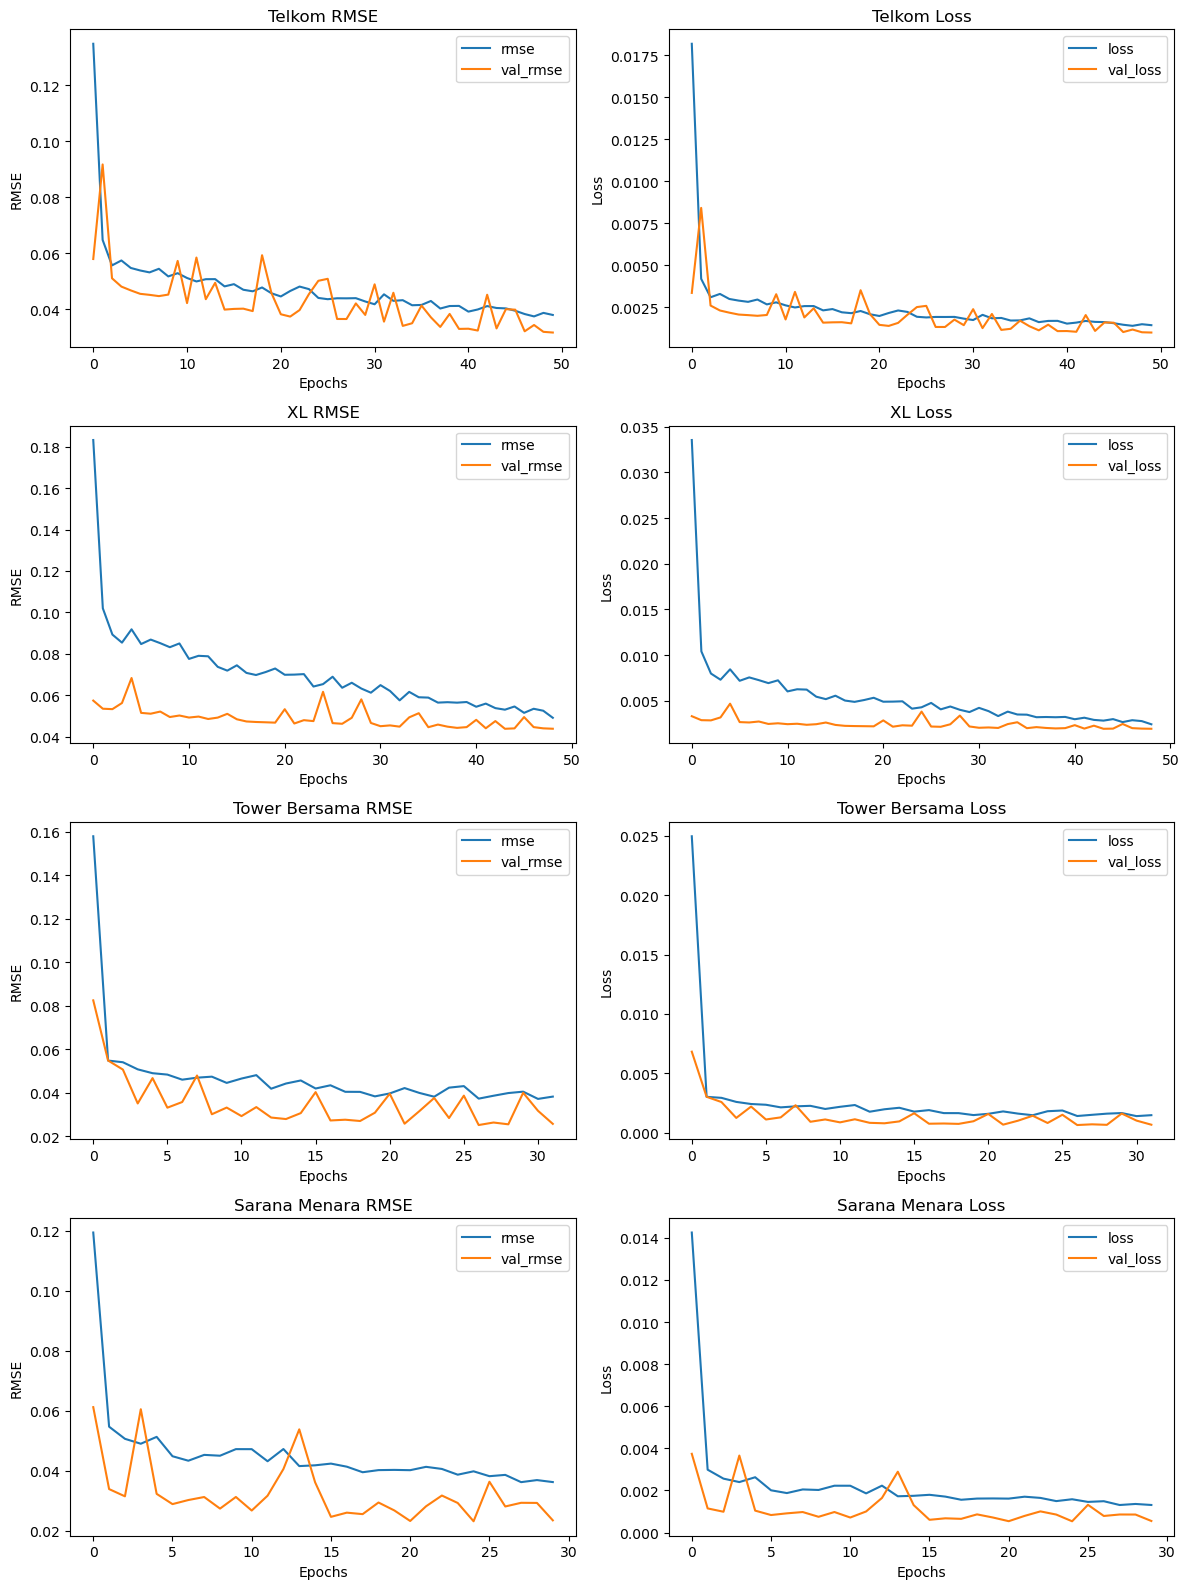

In [35]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

axs[0, 0].plot(telkom_hist.epoch, telkom_hist.history['root_mean_squared_error'], label = "rmse")
axs[0, 0].plot(telkom_hist.epoch, telkom_hist.history['val_root_mean_squared_error'], label = "val_rmse")
axs[0, 0].set_title('Telkom RMSE')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].legend()

axs[0, 1].plot(telkom_hist.epoch, telkom_hist.history['loss'], label="loss")
axs[0, 1].plot(telkom_hist.epoch, telkom_hist.history['val_loss'], label="val_loss")
axs[0, 1].set_title('Telkom Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

axs[1, 0].plot(excl_hist.epoch, excl_hist.history['root_mean_squared_error'], label = "rmse")
axs[1, 0].plot(excl_hist.epoch, excl_hist.history['val_root_mean_squared_error'], label = "val_rmse")
axs[1, 0].set_title('XL RMSE')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('RMSE')
axs[1, 0].legend()

axs[1, 1].plot(excl_hist.epoch, excl_hist.history['loss'], label="loss")
axs[1, 1].plot(excl_hist.epoch, excl_hist.history['val_loss'], label="val_loss")
axs[1, 1].set_title('XL Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

axs[2, 0].plot(tbig_hist.epoch, tbig_hist.history['root_mean_squared_error'], label = "rmse")
axs[2, 0].plot(tbig_hist.epoch, tbig_hist.history['val_root_mean_squared_error'], label = "val_rmse")
axs[2, 0].set_title('Tower Bersama RMSE')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('RMSE')
axs[2, 0].legend()

axs[2, 1].plot(tbig_hist.epoch, tbig_hist.history['loss'], label="loss")
axs[2, 1].plot(tbig_hist.epoch, tbig_hist.history['val_loss'], label="val_loss")
axs[2, 1].set_title('Tower Bersama Loss')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].legend()

axs[3, 0].plot(towr_hist.epoch, towr_hist.history['root_mean_squared_error'], label = "rmse")
axs[3, 0].plot(towr_hist.epoch, towr_hist.history['val_root_mean_squared_error'], label = "val_rmse")
axs[3, 0].set_title('Sarana Menara RMSE')
axs[3, 0].set_xlabel('Epochs')
axs[3, 0].set_ylabel('RMSE')
axs[3, 0].legend()

axs[3, 1].plot(towr_hist.epoch, towr_hist.history['loss'], label="loss")
axs[3, 1].plot(towr_hist.epoch, towr_hist.history['val_loss'], label="val_loss")
axs[3, 1].set_title('Sarana Menara Loss')
axs[3, 1].set_xlabel('Epochs')
axs[3, 1].set_ylabel('Loss')
axs[3, 1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [36]:
def evaluate_model(scaler, model, x_test, stock_data):
    split_index = int(len(stock_data) * 0.7)
    stock_data = stock_data.filter(['Adj Close'])
    adj_close_data = stock_data.values
    
    y_actual = adj_close_data[split_index:, :]
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(((predictions - y_actual) ** 2)))
    
    ape = np.abs((y_actual - predictions) / y_actual)
    mape = np.mean(ape) * 100
    
    print("RMSE: {:.5f}".format(rmse)) 
    print("Mean Absolute Percentage Error: {:.2f}%".format(mape))
    
    plt.figure(figsize=(12,7))
    plt.title('Model real-test prediction')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.plot(predictions, 'blue', label='Prediction')
    plt.plot(y_actual, 'green', label='Actual Value')
    plt.legend()

12/12 [==============================] - 2s 20ms/step
RMSE: 78.16031
Mean Absolute Percentage Error: 1.43%


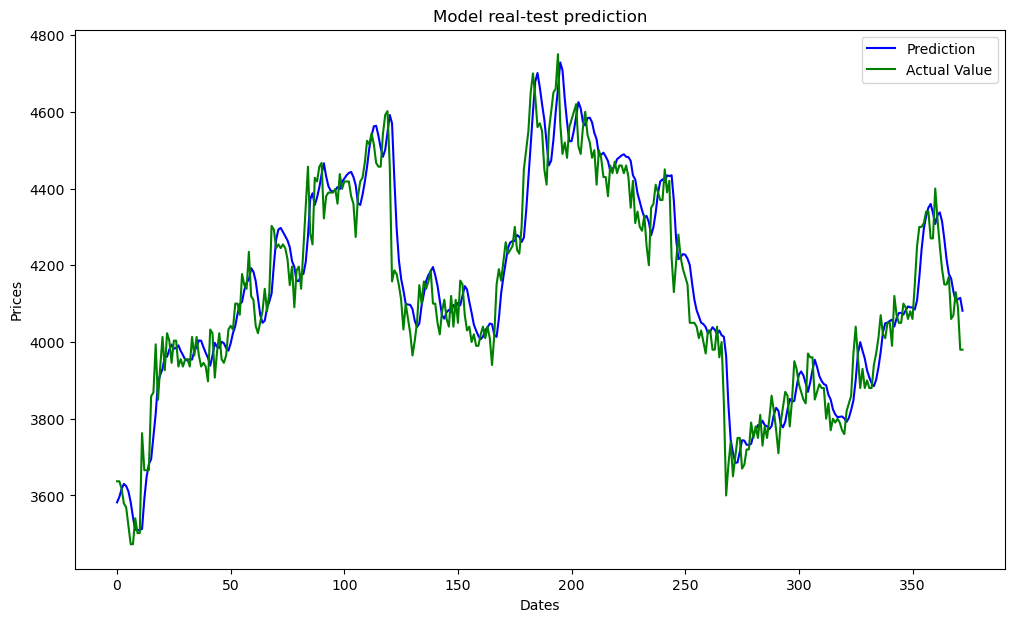

In [37]:
evaluate_model(tlkm_scaler, tlkm_model, tlkm_x_test, tlkm_data)

12/12 [==============================] - 1s 19ms/step
RMSE: 139.65984
Mean Absolute Percentage Error: 5.11%


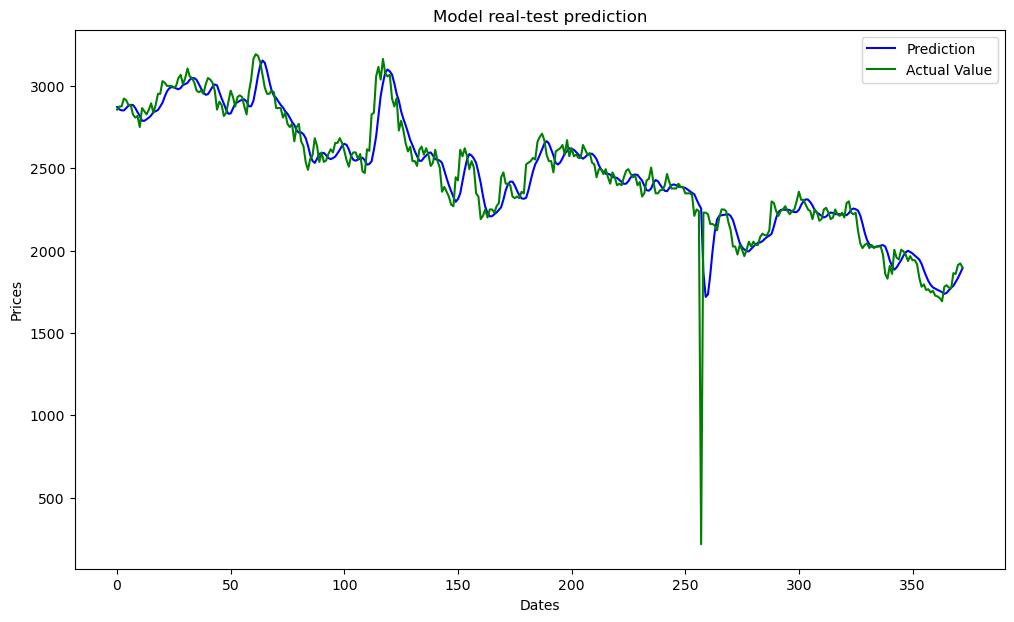

In [38]:
evaluate_model(xl_scaler, excl_model, xl_x_test, xl_data)

12/12 [==============================] - 1s 20ms/step
RMSE: 70.73122
Mean Absolute Percentage Error: 2.13%


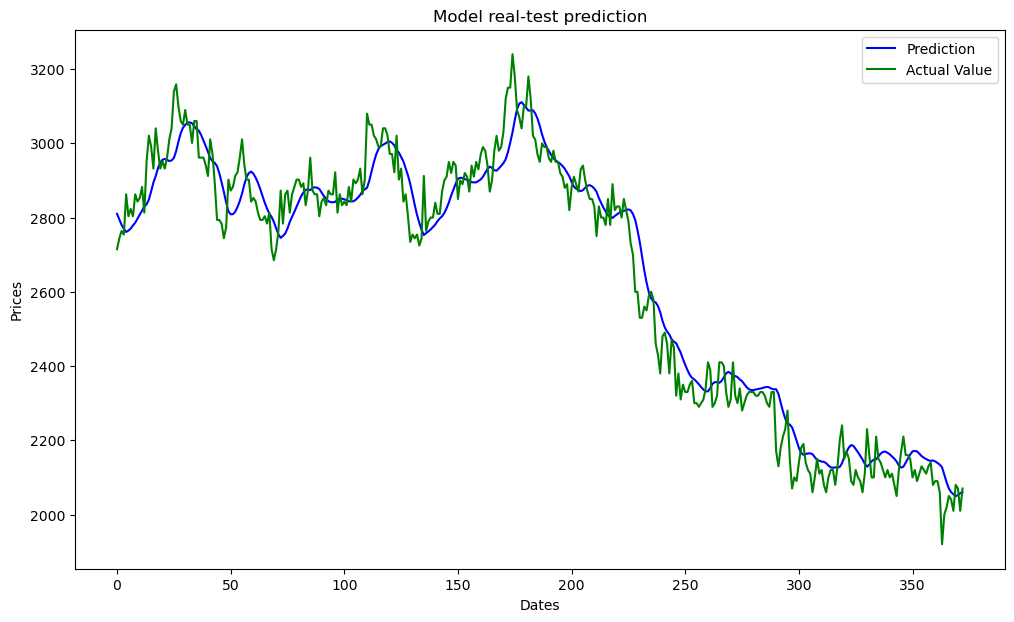

In [39]:
evaluate_model(tbig_scaler, tbig_model, tbig_x_test, tbig_data)

12/12 [==============================] - 1s 24ms/step
RMSE: 25.81101
Mean Absolute Percentage Error: 1.87%


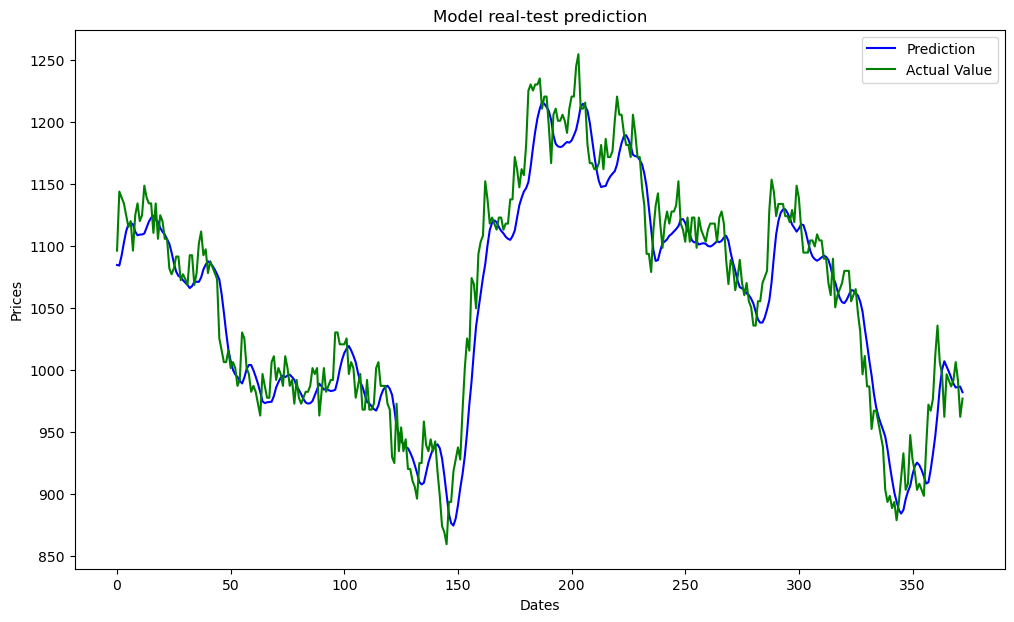

In [40]:
evaluate_model(towr_scaler, towr_model, towr_x_test, towr_data)